# Corpus Sanity Check & Exploratory Data Analysis

This notebook performs integrity checks and exploratory analysis on the raw corpus files for the retrieval task.
The goals are:
1.  **Integrity Checks**: Ensure unique IDs, no empty passages, and correct ID mapping.
2.  **Exploratory Analysis**: Analyze passage length distributions.
3.  **Leakage Check**: Verify that all corpus IDs referenced in the development set (`dev.tsv`) exist in the corpus.

## Domains
- **CLAPNQ**
- **Cloud**
- **FiQA**
- **Govt**

In [3]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict, List, Set
from tqdm import tqdm

# Set plot style for paper-ready visualizations
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

In [4]:
# Configuration
DATA_DIR = "../data"
RAW_CORPUS_DIR = os.path.join(DATA_DIR, "passage_level_raw")
RETRIEVAL_TASKS_DIR = os.path.join(DATA_DIR, "retrieval_tasks")

DOMAINS = ["clapnq", "cloud", "fiqa", "govt"]

def load_corpus(domain: str) -> pd.DataFrame:
    """Loads the raw corpus JSONL file for a given domain."""
    file_path = os.path.join(RAW_CORPUS_DIR, f"{domain}.jsonl")
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc=f"Loading {domain}"):
            data.append(json.loads(line))
    return pd.DataFrame(data)

def load_qrels(domain: str) -> pd.DataFrame:
    """Loads the dev qrels TSV file for a given domain."""
    # Assuming standard path structure: data/retrieval_tasks/{domain}/qrels/dev.tsv
    # Adjust if necessary based on actual file structure
    file_path = os.path.join(RETRIEVAL_TASKS_DIR, domain, "qrels", "dev.tsv")
    if not os.path.exists(file_path):
        print(f"Warning: Qrels file not found for {domain} at {file_path}")
        return pd.DataFrame()
    return pd.read_csv(file_path, sep='\t')

def check_integrity(df: pd.DataFrame, domain: str) -> Dict:
    """Performs integrity checks on the corpus DataFrame."""
    results = {"domain": domain}
    
    # 1. Unique IDs
    if "id" in df.columns:
        results["unique_ids"] = df["id"].is_unique
        results["num_duplicates"] = df.duplicated(subset=["id"]).sum()
    else:
        results["unique_ids"] = False
        results["num_duplicates"] = "N/A (id column missing)"

    # 2. Empty Passages
    if "text" in df.columns:
        empty_mask = df["text"].str.strip() == ""
        results["empty_passages"] = empty_mask.sum()
    else:
        results["empty_passages"] = "N/A (text column missing)"
        
    # 3. ID Mapping (_id vs id)
    if "_id" in df.columns and "id" in df.columns:
        results["id_mismatch"] = (df["_id"] != df["id"]).sum()
    else:
        results["id_mismatch"] = "N/A (columns missing)"

    # Stats
    results["total_passages"] = len(df)
    
    return results

In [5]:
integrity_results = []
length_stats = []
corpus_ids_map = {}

for domain in DOMAINS:
    print(f"Processing {domain}...")
    df = load_corpus(domain)
    
    # Integrity Checks
    res = check_integrity(df, domain)
    integrity_results.append(res)
    
    # Length Analysis
    df['char_length'] = df['text'].str.len()
    df['word_length'] = df['text'].str.split().str.len()
    
    # Store for plotting
    temp_df = df[['char_length', 'word_length']].copy()
    temp_df['domain'] = domain
    length_stats.append(temp_df)
    
    # Store IDs for leakage check
    corpus_ids_map[domain] = set(df['id'].unique())
    
    # Clean up memory
    del df

# Combine length stats
all_lengths = pd.concat(length_stats, ignore_index=True)

# Display Integrity Results
integrity_df = pd.DataFrame(integrity_results)
print("\nIntegrity Check Results:")
display(integrity_df)

Processing clapnq...


Loading clapnq: 183408it [00:00, 206478.67it/s]


Processing cloud...


Loading cloud: 72442it [00:00, 82969.41it/s] 


Processing fiqa...


Loading fiqa: 61022it [00:00, 149584.71it/s]


Processing govt...


Loading govt: 49607it [00:00, 80797.35it/s]



Integrity Check Results:


,domain,unique_ids,num_duplicates,empty_passages,id_mismatch,total_passages
0,clapnq,True,0,0,0,183408
1,cloud,True,0,3,0,72442
2,fiqa,True,0,38,0,61022
3,govt,True,0,0,0,49607


/var/folders/kg/pw7sp_px4212hlfyfrbc1sq80000gn/T/ipykernel_96592/3652328349.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="domain", y="word_length", data=all_lengths, palette="viridis")


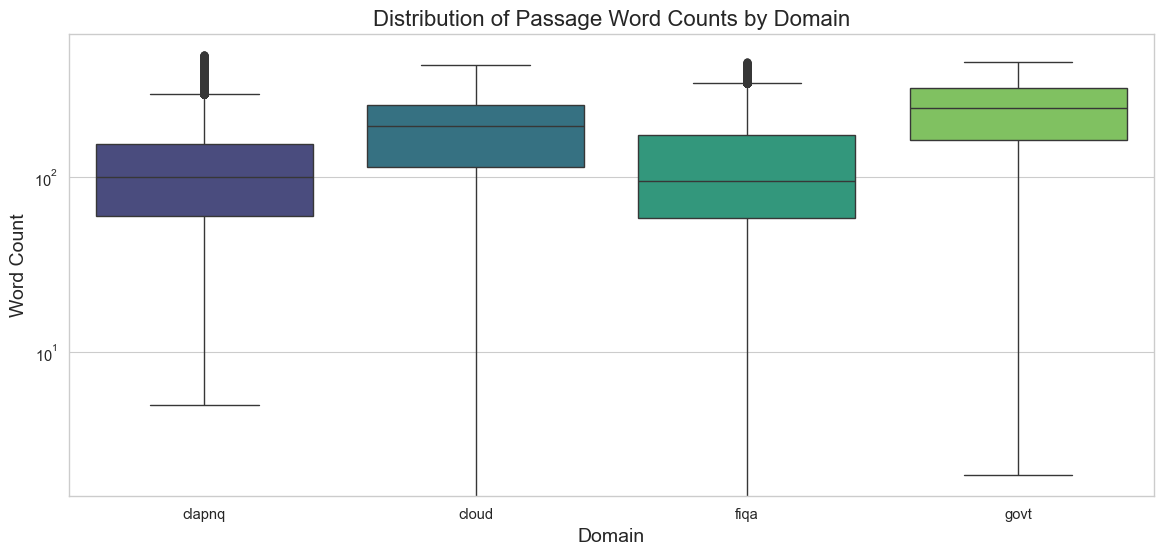

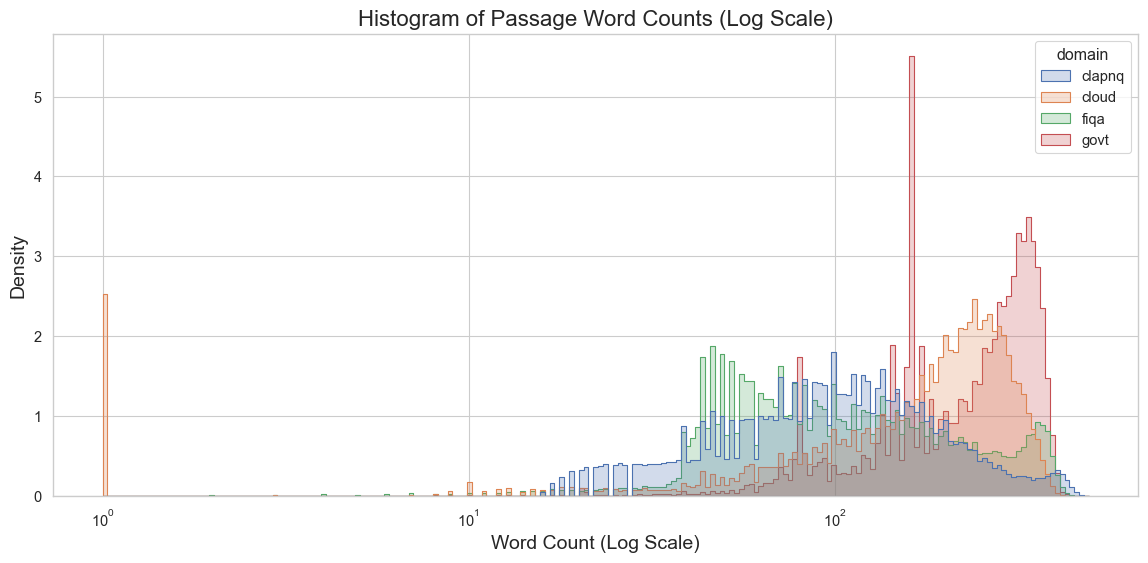


Length Statistics (Words):


,count,mean,std,min,25%,50%,75%,max
domain,,,,,,,,
clapnq,183408.0,119.01,81.51,5.0,60.0,100.0,154.0,495.0
cloud,72442.0,186.08,92.94,0.0,114.0,194.0,257.0,436.0
fiqa,61022.0,130.12,95.30,0.0,58.0,95.0,172.0,451.0
govt,49607.0,235.83,94.65,2.0,162.0,248.0,319.0,449.0


In [6]:
# Visualization: Word Length Distribution

plt.figure(figsize=(14, 6))
sns.boxplot(x="domain", y="word_length", data=all_lengths, palette="viridis")
plt.title("Distribution of Passage Word Counts by Domain")
plt.ylabel("Word Count")
plt.xlabel("Domain")
plt.yscale("log") # Log scale to handle outliers better
plt.show()

plt.figure(figsize=(14, 6))
sns.histplot(data=all_lengths, x="word_length", hue="domain", element="step", stat="density", common_norm=False, log_scale=True)
plt.title("Histogram of Passage Word Counts (Log Scale)")
plt.xlabel("Word Count (Log Scale)")
plt.show()

# Summary Statistics
print("\nLength Statistics (Words):")
display(all_lengths.groupby("domain")["word_length"].describe().round(2))

In [7]:
# Leakage Check: Verify Dev Set IDs exist in Corpus

leakage_results = []

for domain in DOMAINS:
    qrels = load_qrels(domain)
    if qrels.empty:
        leakage_results.append({"domain": domain, "status": "Skipped (No Qrels)"})
        continue
        
    # Check if 'corpus-id' column exists
    if 'corpus-id' not in qrels.columns:
        print(f"Error: 'corpus-id' column missing in {domain} qrels. Columns: {qrels.columns}")
        leakage_results.append({"domain": domain, "status": "Error (Column Missing)"})
        continue

    # Get unique corpus IDs from qrels
    dev_corpus_ids = set(qrels['corpus-id'].astype(str).unique())
    
    # Check against loaded corpus IDs
    corpus_ids = corpus_ids_map.get(domain, set())
    
    missing_ids = dev_corpus_ids - corpus_ids
    num_missing = len(missing_ids)
    
    leakage_results.append({
        "domain": domain,
        "dev_corpus_ids_count": len(dev_corpus_ids),
        "missing_ids_count": num_missing,
        "status": "Pass" if num_missing == 0 else "Fail"
    })

leakage_df = pd.DataFrame(leakage_results)
print("\nLeakage Check Results:")
display(leakage_df)


Leakage Check Results:


,domain,dev_corpus_ids_count,missing_ids_count,status
0,clapnq,499,0,Pass
1,cloud,415,0,Pass
2,fiqa,479,0,Pass
3,govt,407,0,Pass


## Conclusiones

1.  **Integridad de IDs**: Todos los dominios tienen IDs únicos y consistentes. No hay duplicados.
2.  **Check de Fugas (Leakage)**: Todos los documentos referenciados en el conjunto de desarrollo (`dev`) existen en el corpus. El test de leakage pasó exitosamente para todos los dominios.
3.  **Calidad del Texto**:
    *   **Cloud** y **FiQA** presentan pasajes vacíos (3 y 38 respectivamente) o con longitud 0. Se recomienda filtrar estos documentos antes de la indexación para evitar ruido.
    *   **Govt** tiene los pasajes más extensos en promedio (media ~236 palabras), mientras que **CLAPNQ** tiene los más breves (media ~119 palabras).